In [262]:
import matplotlib.pyplot as plt
import numpy as np
from uncertainties import ufloat
from uncertainties import unumpy as unp

from utils import load_data

In [263]:
dists = np.array([5, 10, 16, 22, 28, 34, 40])  # in cm
files = [f"data/Zeitkalibrierung-Na22-BaF2-{d}cm.Spe" for d in dists]

In [264]:
from lmfit.models import GaussianModel


def get_time_center(filepath: str):
    data, _ = load_data(filepath, only_roi=False)
    roi = np.arange(1950, 2350)
    data = data[roi]
    model = GaussianModel()

    # uncertainty of mcb is <1% differential nonlinearity, choose worst case
    adapted_data = data * 0.01
    adapted_data[adapted_data == 0.] = 1
    weights = np.array(1.0 / adapted_data)

    init_values = {
        'amplitude': {'value': 1900, 'min': 0, 'max': 2200},
        'center': {'value': roi[np.where(data == max(data))[0][0]], 'min': roi[0], 'max': roi[-1]},
        'sigma': {'value': 20, 'min': 0, 'max': 1000},
    }
    params = model.make_params(**init_values)
    result = model.fit(data, params, x=list(roi), weights=weights)
    efine = result.eval_uncertainty(t=roi, sigma=2)
    pfine = result.dely_predicted
    fitted_params = result.params
    # fitted_params.pretty_print()

    x = np.linspace(min(roi), max(roi), 1000)
    y = model.eval(x=x, params=fitted_params)
    # plt.fill_between(roi, data-pfine, data+pfine,
    #                  color="#c0c0c0", label=r'$2\sigma$ predicted interval')
    plt.plot(x, y, linewidth=.4, c='orange', label='Gauss Fit')
    plt.scatter(roi, data, s=0.1, label='Flugzeitspektrum')
    plt.grid(alpha=.3)
    plt.legend()
    plt.xlabel('Channel')
    plt.ylabel('Counts')
    plt.show()

    center = ufloat(fitted_params['center'].value, fitted_params['center'].stderr)
    fwhm = ufloat(fitted_params['fwhm'].value, fitted_params['fwhm'].stderr)
    return [center, fwhm]

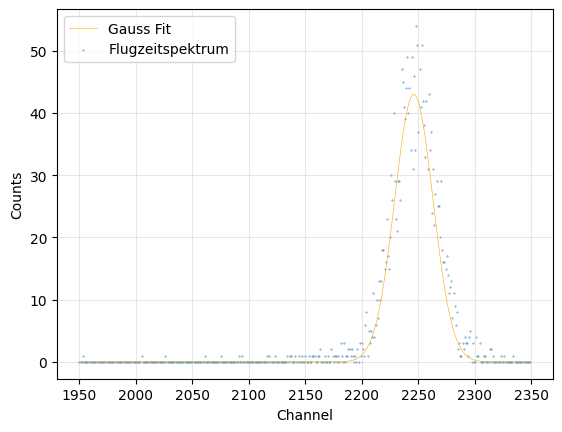

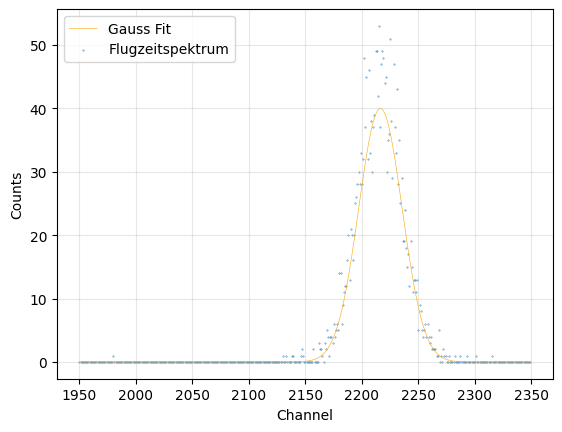

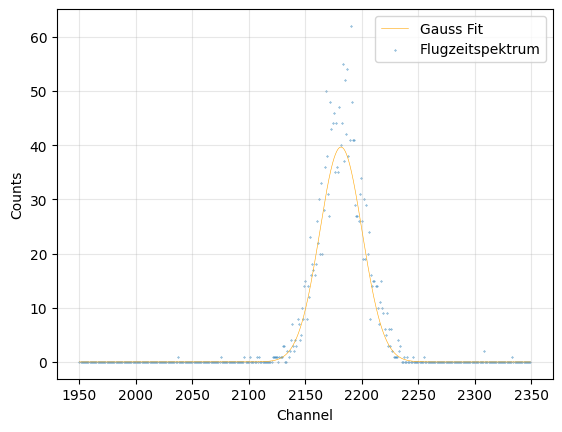

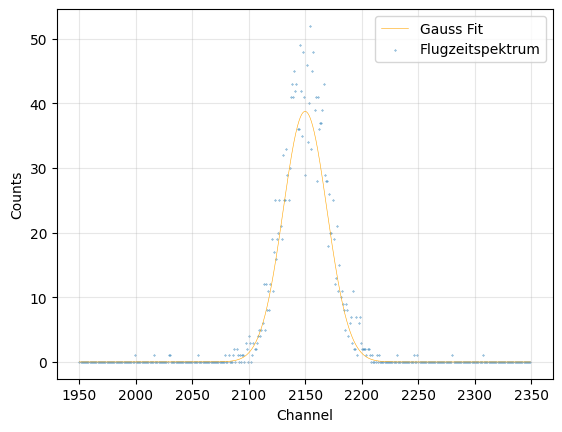

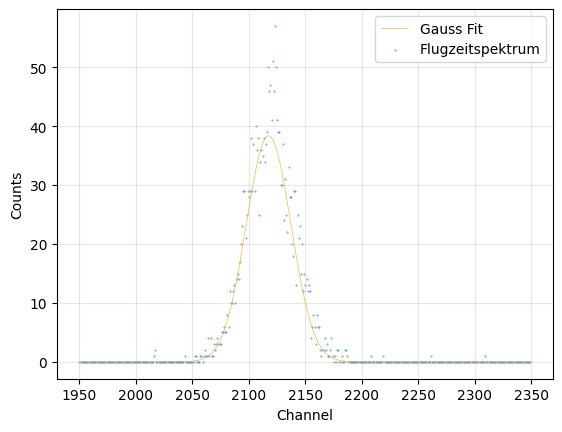

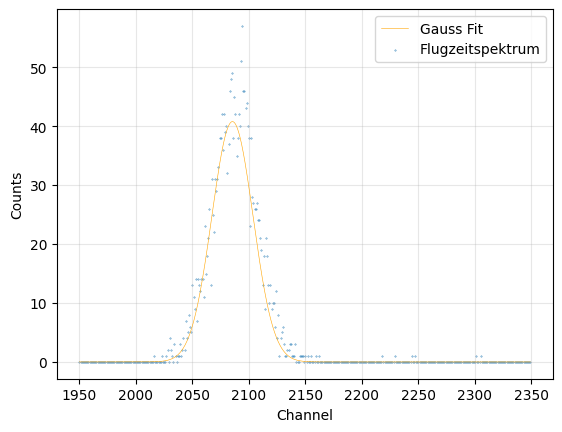

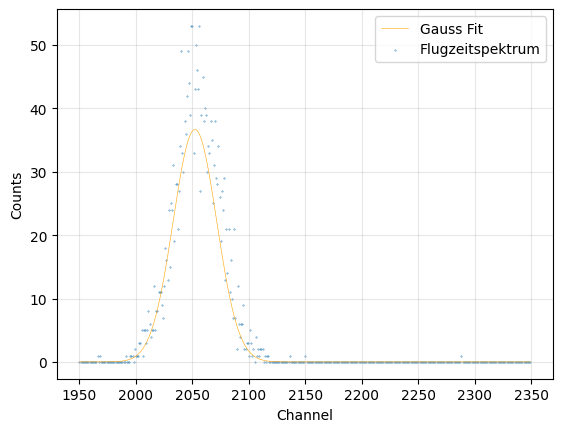

In [265]:
vals = []
stds = []
data = np.array([get_time_center(file) for file in files]).T
centers = data[0]
fwhms = data[1]
for c in centers:
    vals.append(c.n)
    stds.append(c.s)
centers = unp.uarray(vals, stds)

In [266]:
print(centers)
print(fwhms)

[2245.886606459847+/-0.44912488064614325
 2216.323028414999+/-0.28881304746050973
 2181.4136082967643+/-0.2839239467838714
 2149.687727461048+/-0.3193350233568622
 2117.375633943224+/-0.2884072496707488
 2085.394440628597+/-0.3280891386251092
 2052.1937203794587+/-0.3071600642584531]
[40.008655104346374+/-0.698531550969515
 45.20624617840215+/-0.48811457282861653
 44.18022887112923+/-0.4623252616265436
 45.60323647581167+/-0.5481962050430031
 46.73413353996828+/-0.47222527218480975
 42.862165473432675+/-0.5204646321143238
 45.33302031665849+/-0.5282765117428221]


In [267]:
cen_vals = unp.nominal_values(centers)
cen_stds = unp.std_devs(centers)

In [268]:
from lmfit.models import LinearModel

lin_model = LinearModel()
init_values_lin = {
    'slope': {'value': -0.17, 'min': -1, 'max': 0},
    'intercept': {'value': 2250, 'min': 2200, 'max': 2500},
}
params_lin = lin_model.make_params(**init_values_lin)

In [269]:
from scipy.constants import c

lightspeed = c * 100 * 10 ** -12  # in cm/ps
print('lightspeed:', lightspeed, 'cm/ps')
dists = np.array(dists - min(dists))
dists = unp.uarray(dists, np.zeros_like(dists) + .1)
times = np.array(dists) / lightspeed  # in ps
time_vals = unp.nominal_values(times)
time_stds = unp.std_devs(times)
print(times, "ps")

lightspeed: 0.0299792458 cm/ps
[0.0+/-3.335640951981521 166.78204759907604+/-3.335640951981521
 366.9205047179673+/-3.335640951981521
 567.0589618368585+/-3.335640951981521
 767.1974189557498+/-3.335640951981521
 967.335876074641+/-3.335640951981521
 1167.4743331935322+/-3.335640951981521] ps


In [270]:
cen_weights = 1.0 / (cen_stds + unp.std_devs(times))

In [271]:
lin_result = lin_model.fit(cen_vals, params_lin, x=unp.nominal_values(times), weights=cen_weights)
fitted_params_lin = lin_result.params
fitted_params_lin.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
intercept      2244     2200     2500   0.9387     True     None     None
slope       -0.1647       -1        0 0.001348     True     None     None


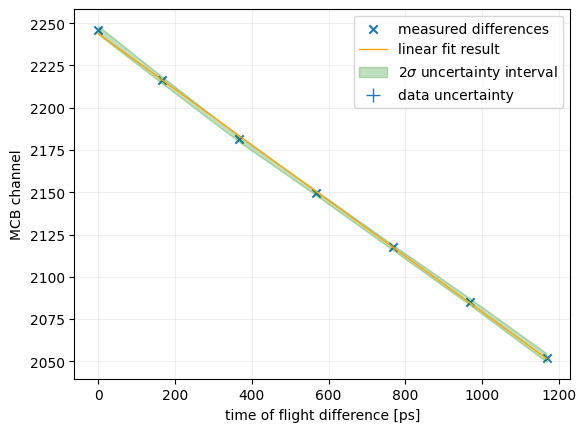

In [272]:
x = np.linspace(min(time_vals), max(time_vals), 10000)
y = lin_model.eval(x=x, params=fitted_params_lin)
uncert = lin_result.eval_uncertainty(x=time_vals, sigma=2)
plt.scatter(time_vals, cen_vals, label='measured differences', marker='x')
plt.errorbar(time_vals, cen_vals, xerr=time_stds, yerr=cen_stds, fmt='none', elinewidth=1, label='data uncertainty')
plt.plot(x, y, linewidth=1, c='orange', label='linear fit result')
plt.fill_between(time_vals, cen_vals - uncert, cen_vals + uncert, alpha=0.25, color='green',
                 label=r"$2\sigma$ uncertainty interval")
plt.grid(alpha=.2)
plt.legend()
plt.xlabel('time of flight difference [ps]')
plt.ylabel('MCB channel')
plt.show()

In [273]:
time_resolution = abs(1. / ufloat(fitted_params_lin["slope"].value, fitted_params_lin["slope"].stderr))
print(f'Time resolution for BAF2 detector: {time_resolution} ps/channel')
print(np.sum(fwhms)/len(fwhms))

Time resolution for BAF2 detector: 6.07+/-0.05 ps/channel
44.28+/-0.20
